# Analyze sea ice thickness proxy product

Notebook used to analyze created sea ice thickness proxy product (1992-2020). Plot sea ice thickness for given month and year and plot SIT trend.


### Plot sea ice thickness map
Plot proxy SIT map for given month and year. 

In [53]:
#Import libraries
%matplotlib inline
import numpy as np
import xarray as xr
import calendar
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m')

In [54]:
#Select month and year to plot
m = 4
year = 2020

In [55]:
direc = '../../data/proxy_SIT/'
sit = xr.open_dataset(direc+'predic_sit_19932020_'+f"{m:02}"+'.nc')

y = np.where(sit.year==year)[0][0]

In [56]:
def plot_CAA(plot):
    fig=plt.figure(figsize=(4,2),dpi=200)
    ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-99, central_latitude=70, globe=None))
    ax.coastlines(resolution='50m',linewidth=0.5)
    ax.set_extent([-140,-57,62,84],crs=ccrs.PlateCarree())
    ax.gridlines(linewidth=0.3, color='k', alpha=0.5, linestyle=':')
    im = plt.scatter(sit.lon, sit.lat, c=plot, cmap='Spectral_r',vmin=0,vmax=3,s=2, transform=ccrs.PlateCarree())
    ax.add_feature(land_50m, facecolor='#eeeeee')
    cbar = fig.colorbar(im, ax=ax, label='m',extend='max',fraction=0.046, pad=0.04)
    cbar.ax.locator_params(nbins=4)
    cbar.ax.tick_params(labelsize=6)

Text(0.5, 1.0, 'Proxy sea ice thickness (April 2020, mean)')

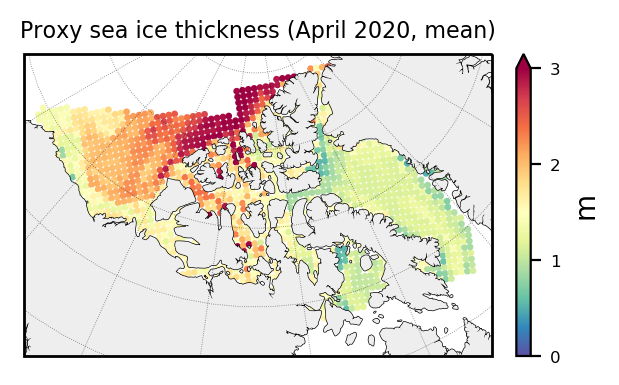

In [57]:
plot_CAA(sit.sit_mean[y,:].values)
plt.title(f'Proxy sea ice thickness ({calendar.month_name[m]} {str(year)}, mean)',fontsize=8)

---------------------------------------------------------------------

### Plot SIT trend
Plot sea ice thickness trend for given month and years

In [58]:
from scipy import stats
import shapefile as shp  
from shapely.geometry import Point, shape

Select month, start year and end year. Minimum year is 1992, maximum year is 2020

In [59]:
m = 4
year_1 = 1992   
year_2 = 2020 

In [60]:
direc = '../../data/proxy_SIT/'
sit = xr.open_dataset(direc+'predic_sit_19932020_'+f"{m:02}"+'.nc')
sit = sit.drop(1997, dim='year')
sit['myi_conc'] = (['year', 'n'], np.nansum(sit.dataset_X[:,11:14,:],axis=1))
sit['fyi_conc'] = (['year', 'n'], np.nansum(sit.dataset_X[:,5:11,:],axis=1))

y1 = np.where(sit.year==year_1)[0][0]
y2 = np.where(sit.year==year_2)[0][0]

p_value = np.zeros(sit.dims['n'])
trend_sit = np.zeros(sit.dims['n'])
for i in range(sit.dims['n']):
    x=sit.year[y1:y2+1]
    y=sit.sit_mean[y1:y2+1,i]
    trend_sit[i], intercept, r_value, p_value[i], std_err = stats.linregress(x, y)

C:\Users\zq19140\AppData\Local\Continuum\anaconda3\envs\icesat\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).
  This is separate from the ipykernel package so we can avoid doing imports until


Add SIT correction for MYI and FYI when there is a trend in PIOMAS dataset

In [61]:
if m==4:
    corr = 3.2 #cm/yr
    corr_f = 1.8 #cm/yr
elif m==11:
    corr = 2.8 #cm/yr
    corr_f = 0
elif m==12:
    corr = 3.2
    corr_f = 1.3
elif m==1:
    corr = 2.4
    corr_f = 1.2
elif m==2:
    corr = 2.9
    corr_f = 1.5
elif m==3:
    corr = 3.4
    corr_f = 1.7
    
corr_sit = np.zeros((sit.sit_mean.values.shape))
for y in range(len(sit.year)):
    yr = sit.year.values[y]
    yr_dif = 2010-yr
    if yr_dif<0:
        yr_dif=0
    corr_sit[y,:] = sit.sit_mean[y,:] + corr/100*yr_dif*sit.myi_conc[y,:] + corr_f/100*yr_dif*sit.fyi_conc[y,:]

sit['sit_mean_corr'] = (['year', 'n'], corr_sit)

p_value_corr = np.zeros(sit.dims['n'])
trend_sit_corr = np.zeros(sit.dims['n'])
for i in range(sit.dims['n']):
    x=sit.year[y1:y2+1]
    y=sit.sit_ku[y1:y2+1,i]
    trend_sit_corr[i], intercept, r_value, p_value_corr[i], std_err = stats.linregress(x, y)

In [62]:
regions_f = '../../data/misc/v200_CISIRR_Regions_4326_merge.shp'
sf = shp.Reader(regions_f)
regions = ['cwa04_00','cea12_00','cwa01_00','tew02_00']

Find timeseries and trend in regions

In [63]:
# Check in which CISIRR Region the grid cells are
idx = []
shp1 = shp.Reader('../../data/misc/v200_CISIRR_Regions_4326_merge.shp') #open the shapefile
all_shapes = shp1.shapes() # get all the polygons
all_records = shp1.records()     
len_f = sit.dims['n']
location = []; p=0
for i in range(len_f):
    pt = (sit.lon.values[i], sit.lat.values[i])  
    for k in range (len(all_shapes)):             
        boundary = all_shapes[k]
        if Point(pt).within(shape(boundary)):
            location.append(all_records[k][3])
            p=1
    if p==0:
        location.append(' ')
    p=0
sit['location'] = (['n'], np.array(location))

   
def plt_trend(sit, name, region, c, subfig, ylim, j,k):
    #Find timeseries and trend in subregion and add subplot
    idx = []
    for i in range(len(sit.location)):
        if sit.location[i]==region:
            idx.append(i)
    
    x = sit.year
    y = np.nanmean(sit.sit_mean[:,idx],axis=1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    trend_sit = slope
    
    x = sit.year
    y = np.nanmean(sit.sit_mean_corr[:,idx],axis=1)
    slope_corr, intercept_corr, r_value, p_value_corr, std_err = stats.linregress(x, y)
    trend_sit = slope

    ax = plt.subplot2grid((4,2), (j,k)) 
    
    ax.plot(sit.year, np.nanmean(sit.sit_mean[:,idx],axis=1), c=c, marker='o', markersize=4)
    ax.plot(sit.year, slope*sit.year+intercept, c=c, linestyle='--', linewidth=1)
    ax.plot(sit.year, np.nanmean(sit.sit_mean_corr[:,idx],axis=1), c=c, marker='o', alpha=0.5, markersize=4)
    ax.plot(sit.year, slope_corr*sit.year+intercept_corr, c=c, linestyle='--', linewidth=1, alpha=0.5)
    ax.grid(linestyle=':')
    ax.set_ylabel('sea ice thickness [m]', fontsize=8)
#    ax.set_ylim(ylim)
    ax.tick_params(axis='both', labelsize=7)
    plt.title(name, fontsize=10)
    ax.text(0.03,0.05,subfig, fontsize=12, transform=ax.transAxes)
    if p_value<0.05:
        ax.text(0.95,0.085,'proxy trend: '+str(np.round(trend_sit*100,2))+' cm/yr', 
                fontsize=8,horizontalalignment='right',transform=ax.transAxes)
    else:
        ax.text(0.95,0.085,'proxy trend: '+str(np.round(trend_sit*100,2))+' cm/yr', 
                fontsize=8,horizontalalignment='right',alpha=0.5,transform=ax.transAxes)
    if p_value_corr<0.05:
        ax.text(0.95,0.025,'corr trend:  '+str(np.round(slope_corr*100,2))+' cm/yr', 
                fontsize=8,horizontalalignment='right',transform=ax.transAxes)
    else:
        ax.text(0.95,0.025,'corr trend:  '+str(np.round(slope_corr*100,2))+' cm/yr', 
                fontsize=8,horizontalalignment='right',alpha=0.5,transform=ax.transAxes)
     
            



C:\Users\zq19140\AppData\Local\Continuum\anaconda3\envs\icesat\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


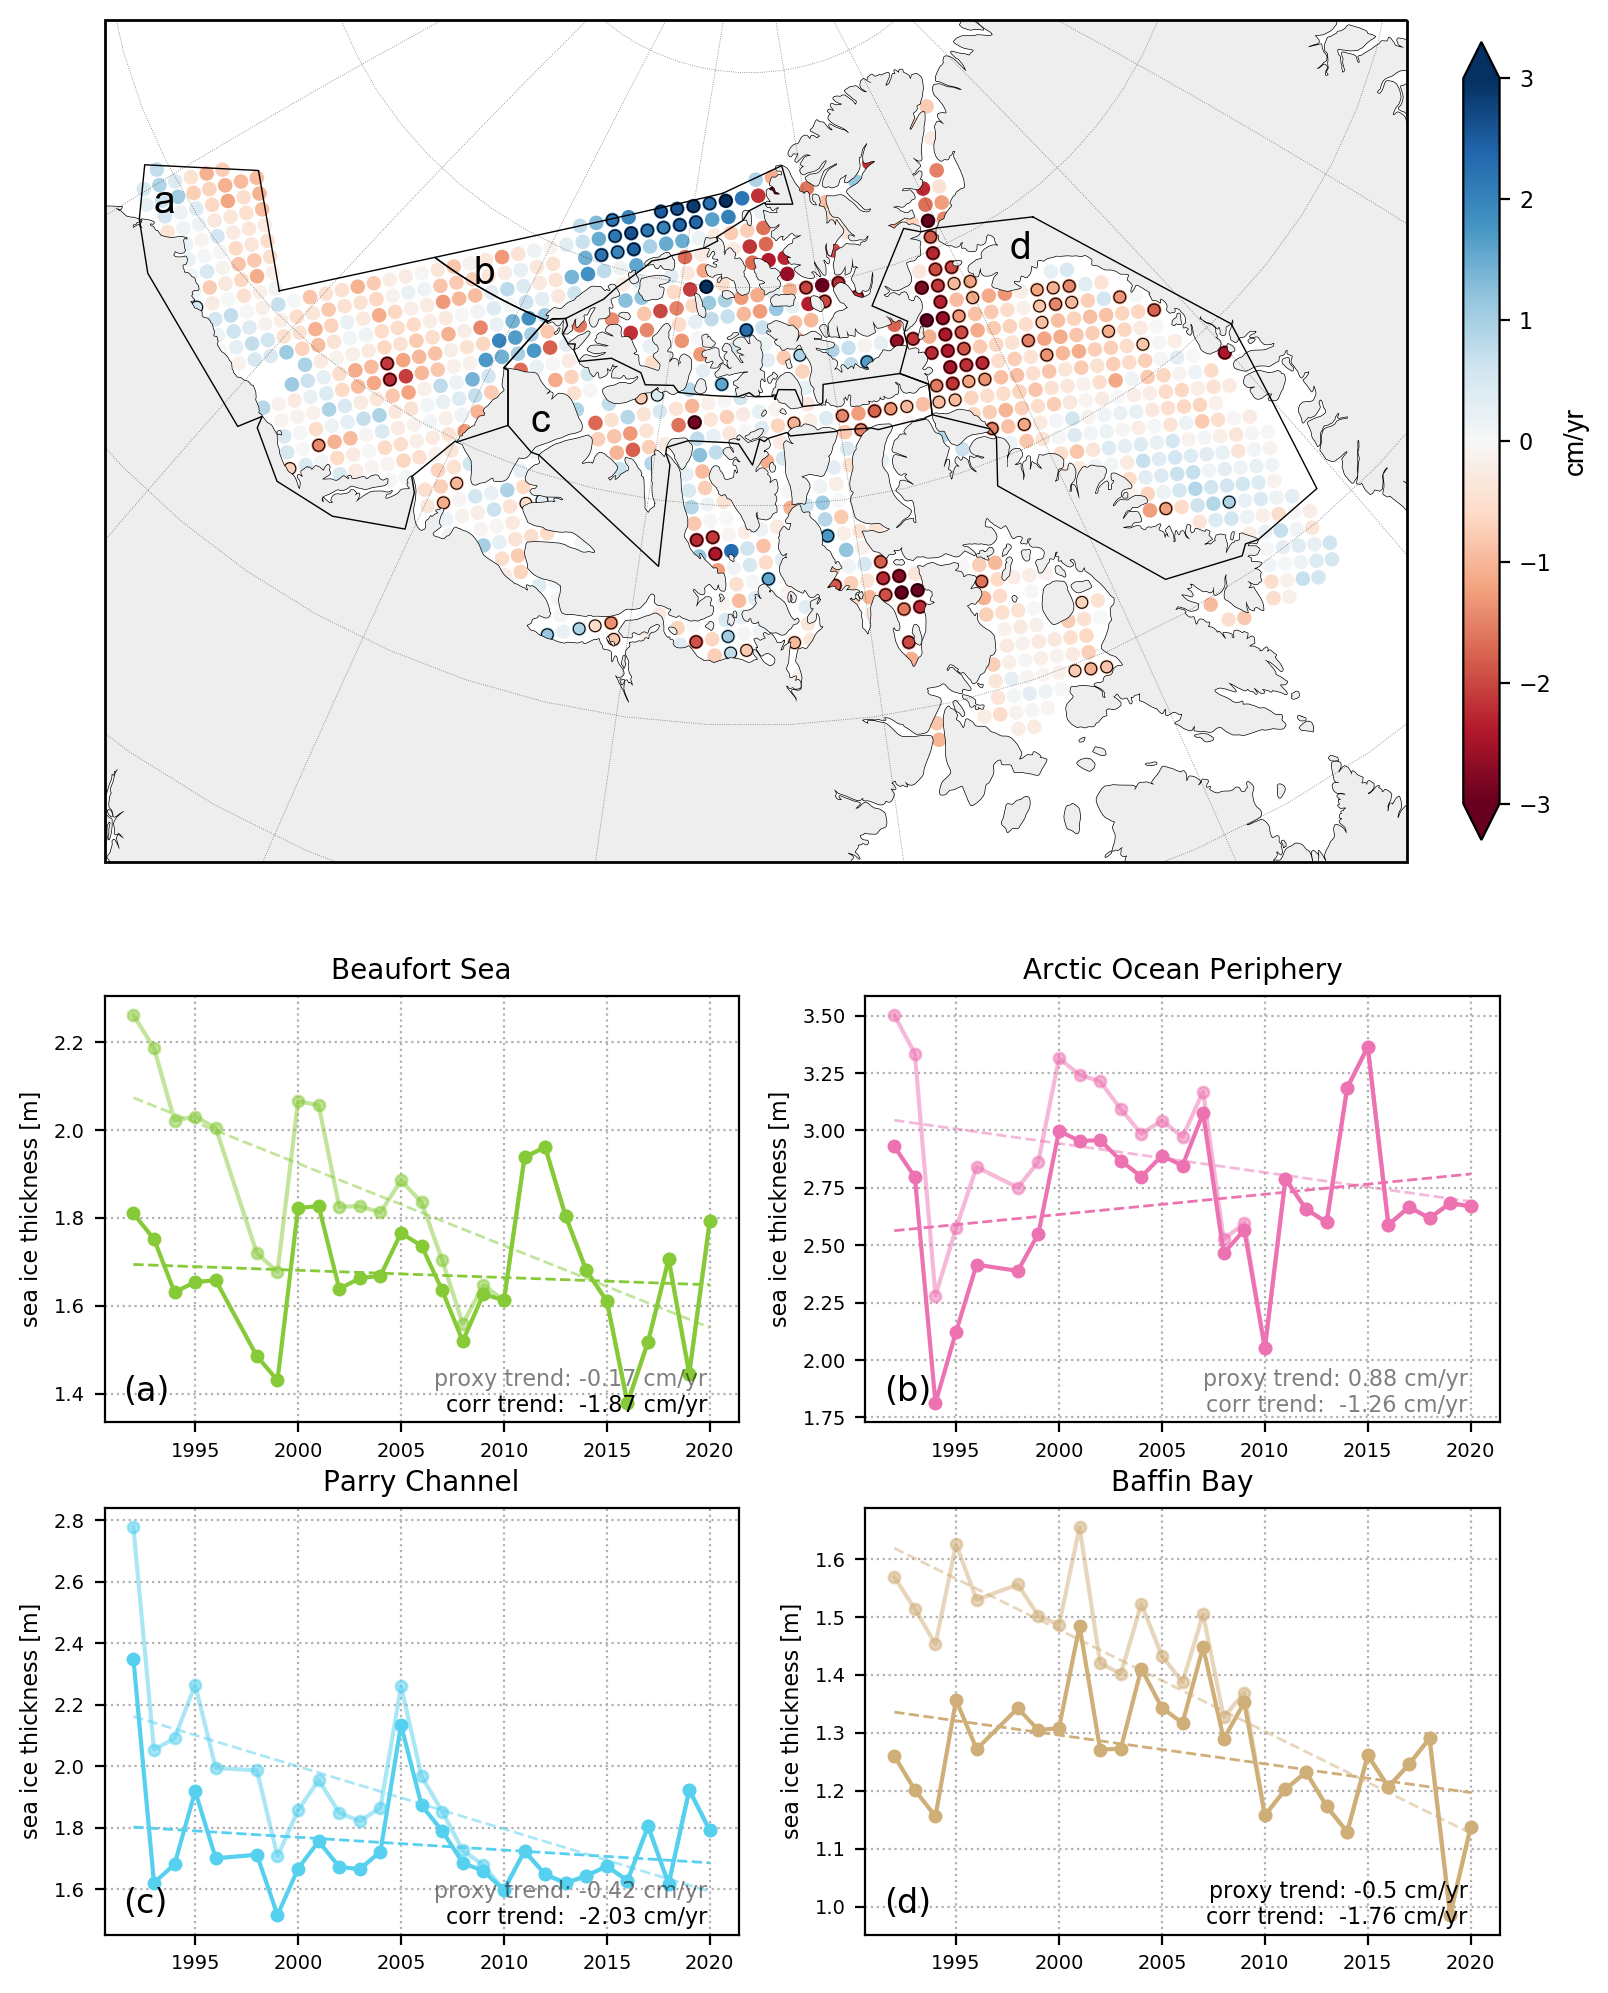

In [66]:
fig = plt.figure(figsize=(9,13),dpi=200)

ax1 = plt.subplot2grid((4,2), (0,0), colspan=2, rowspan=2,
                       projection=ccrs.Orthographic(central_longitude=-99, central_latitude=70, globe=None))
ax1.coastlines(resolution='50m',linewidth=0.5)
ax1.set_extent([-140,-57,62,84],crs=ccrs.PlateCarree())
ax1.gridlines(linewidth=0.3, color='k', alpha=0.5, linestyle=':')
im = ax1.scatter(sit.lon, sit.lat, c=trend_sit*100, cmap='RdBu',vmin=-3,vmax=3,s=18,transform=ccrs.PlateCarree())
ax1.scatter(sit.lon[p_value<0.05], sit.lat[p_value<0.05], facecolors='none',
            s=18, edgecolor='black', linewidth=0.4, transform=ccrs.PlateCarree())
ax1.scatter(sit.lon[p_value_corr<0.05], sit.lat[p_value_corr<0.05], facecolors='none',
            s=18, edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())
for j in range(len(sf.records())):
    shape1 = sf.shapeRecords()[j]
    idx = sf.records()[j][3]
    if idx in regions:
        x = [i[0] for i in shape1.shape.points[:]]
        y = [i[1] for i in shape1.shape.points[:]]
        ax1.plot(x,y, c='black', linewidth=0.5, transform=ccrs.PlateCarree())
ax1.add_feature(land_50m, facecolor='#eeeeee')
cbar = fig.colorbar(im,fraction=0.026, pad=0.04,extend='both')
cbar.ax.locator_params(nbins=7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label='cm/yr',fontsize=10,fontname='Arial')
ax1.text(-160,71, 'a',fontname='Arial', fontsize=14, transform=ccrs.PlateCarree())
ax1.text(-132,76, 'b',fontname='Arial', fontsize=14, transform=ccrs.PlateCarree()) 
ax1.text(-120,73, 'c',fontname='Arial', fontsize=14, transform=ccrs.PlateCarree())
ax1.text(-66,76.8, 'd',fontname='Arial', fontsize=14, transform=ccrs.PlateCarree())

plt_trend(sit, 'Beaufort Sea', 'cwa01_00', '#86CA38', '(a)', [1,3], 2,0)
plt_trend(sit, 'Arctic Ocean Periphery', 'tew02_00', '#ED72B2', '(b)', [1,4], 2,1)
plt_trend(sit, 'Parry Channel', 'cwa04_00', '#55D0EF', '(c)', [1,3], 3,0)
plt_trend(sit, 'Baffin Bay', 'cea12_00', '#D0AE78', '(d)', [0.5,2], 3,1)
                         

fig.tight_layout()       